In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fsd50k/FSD50k/FSD50K.ground_truth/dev.csv
/kaggle/input/fsd50k/FSD50k/FSD50K.ground_truth/vocabulary.csv
/kaggle/input/fsd50k/FSD50k/FSD50K.ground_truth/eval.csv
/kaggle/input/fsd50k/FSD50k/FSD50K.dev_audio/236565.wav
/kaggle/input/fsd50k/FSD50k/FSD50K.dev_audio/354313.wav
/kaggle/input/fsd50k/FSD50k/FSD50K.dev_audio/87250.wav
/kaggle/input/fsd50k/FSD50k/FSD50K.dev_audio/254636.wav
/kaggle/input/fsd50k/FSD50k/FSD50K.dev_audio/184742.wav
/kaggle/input/fsd50k/FSD50k/FSD50K.dev_audio/373004.wav
/kaggle/input/fsd50k/FSD50k/FSD50K.dev_audio/247553.wav
/kaggle/input/fsd50k/FSD50k/FSD50K.dev_audio/31934.wav
/kaggle/input/fsd50k/FSD50k/FSD50K.dev_audio/343901.wav
/kaggle/input/fsd50k/FSD50k/FSD50K.dev_audio/374872.wav
/kaggle/input/fsd50k/FSD50k/FSD50K.dev_audio/19212.wav
/kaggle/input/fsd50k/FSD50k/FSD50K.dev_audio/265181.wav
/kaggle/input/fsd50k/FSD50k/FSD50K.dev_audio/13961.wav
/kaggle/input/fsd50k/FSD50k/FSD50K.dev_audio/398992.wav
/kaggle/input/fsd50k/FSD50k/FSD50K.dev_audio

In [3]:
!pip install torch torchvision torchaudio
!pip install librosa soundfile pandas numpy tqdm pyyam

ERROR: Could not find a version that satisfies the requirement pyyam (from versions: none)
ERROR: No matching distribution found for pyyam


In [4]:
!git clone https://github.com/qiuqiangkong/panns_transfer_to_gtzan.git
%cd panns_transfer_to_gtzan

Cloning into 'panns_transfer_to_gtzan'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 31 (delta 8), reused 8 (delta 8), pack-reused 11 (from 1)
Receiving objects: 100% (31/31), 15.48 KiB | 480.00 KiB/s, done.
Resolving deltas: 100% (10/10), done.
/kaggle/working/panns_transfer_to_gtzan


In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import librosa
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [6]:
GT_PATH = "/kaggle/input/fsd50k/FSD50k/FSD50K.ground_truth/dev.csv"
AUDIO_DIR = "/kaggle/input/fsd50k/FSD50k/FSD50K.dev_audio"

In [7]:
import pandas as pd
import os

gt = pd.read_csv(GT_PATH)

print("✅ dev.csv loaded")
print("Rows:", len(gt))
print(gt.head())

print("\nAudio dir exists:", os.path.exists(AUDIO_DIR))

✅ dev.csv loaded
Rows: 40966
   fname                                             labels  \
0  64760  Electric_guitar,Guitar,Plucked_string_instrume...   
1  16399  Electric_guitar,Guitar,Plucked_string_instrume...   
2  16401  Electric_guitar,Guitar,Plucked_string_instrume...   
3  16402  Electric_guitar,Guitar,Plucked_string_instrume...   
4  16404  Electric_guitar,Guitar,Plucked_string_instrume...   

                                            mids  split  
0  /m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf  train  
1  /m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf  train  
2  /m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf  train  
3  /m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf  train  
4  /m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf  train  

Audio dir exists: True


In [8]:
import os

for root, dirs, files in os.walk("/kaggle/input/fsd50k"):
    for f in files:
        if f.endswith(".csv"):
            print(os.path.join(root, f))

/kaggle/input/fsd50k/FSD50k/FSD50K.ground_truth/dev.csv
/kaggle/input/fsd50k/FSD50k/FSD50K.ground_truth/vocabulary.csv
/kaggle/input/fsd50k/FSD50k/FSD50K.ground_truth/eval.csv
/kaggle/input/fsd50k/FSD50k/FSD50K.metadata/collection/vocabulary_collection_dev.csv
/kaggle/input/fsd50k/FSD50k/FSD50K.metadata/collection/collection_eval.csv
/kaggle/input/fsd50k/FSD50k/FSD50K.metadata/collection/collection_dev.csv
/kaggle/input/fsd50k/FSD50k/FSD50K.metadata/collection/vocabulary_collection_eval.csv


In [9]:
all_labels = sorted(set(",".join(gt["labels"]).split(",")))
label_to_idx = {l:i for i,l in enumerate(all_labels)}

In [10]:
# Build label vocabulary
all_labels = sorted(set(",".join(gt["labels"]).split(",")))
label_to_idx = {l: i for i, l in enumerate(all_labels)}
idx_to_label = {i: l for l, i in label_to_idx.items()}

NUM_CLASSES = len(all_labels)
print("✅ Number of classes:", NUM_CLASSES)

✅ Number of classes: 200


In [11]:
import librosa
import numpy as np
import os
import time
from tqdm import tqdm

FEATURE_DIR = "/kaggle/working/fsd50k_mel"
os.makedirs(FEATURE_DIR, exist_ok=True)

SAMPLE_RATE = 32000
DURATION = 5          # seconds (fast)
TARGET_LEN = SAMPLE_RATE * DURATION
N_MELS = 64
N_FFT = 1024
HOP_LENGTH = 320

start_time = time.time()
processed = 0
skipped = 0

print("🎵 Starting log-mel precomputation...\n")

for _, row in tqdm(
    gt.iterrows(),
    total=len(gt),
    desc="Precomputing log-mel",
    unit="file",
    dynamic_ncols=True
):
    fname = str(row["fname"])
    audio_path = os.path.join(AUDIO_DIR, fname + ".wav")
    out_path = os.path.join(FEATURE_DIR, fname + ".npy")

    # Skip if already processed
    if os.path.exists(out_path):
        skipped += 1
        continue

    try:
        y, _ = librosa.load(audio_path, sr=SAMPLE_RATE, mono=True)

        # Trim / pad
        if len(y) > TARGET_LEN:
            y = y[:TARGET_LEN]
        else:
            y = np.pad(y, (0, TARGET_LEN - len(y)))

        mel = librosa.feature.melspectrogram(
            y=y,
            sr=SAMPLE_RATE,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH,
            n_mels=N_MELS,
            power=2.0
        )

        mel_db = librosa.power_to_db(mel).astype(np.float32)
        np.save(out_path, mel_db)

        processed += 1

    except Exception as e:
        skipped += 1
        continue

elapsed = time.time() - start_time

print("\n✅ Log-mel precomputation complete!")
print(f"📊 Processed files : {processed}")
print(f"⏭️  Skipped files   : {skipped}")
print(f"⏱️  Total time      : {elapsed/60:.2f} minutes")
print(f"📁 Features saved to: {FEATURE_DIR}")

🎵 Starting log-mel precomputation...



Precomputing log-mel: 100%|██████████| 40966/40966 [32:07<00:00, 21.26file/s]  


✅ Log-mel precomputation complete!
📊 Processed files : 40966
⏭️  Skipped files   : 0
⏱️  Total time      : 32.12 minutes
📁 Features saved to: /kaggle/working/fsd50k_mel


In [12]:
import torch
from torch.utils.data import Dataset
import numpy as np
import os

class FSD50KMelDataset(Dataset):
    def __init__(self, df, feature_dir):
        self.df = df.reset_index(drop=True)
        self.feature_dir = feature_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load precomputed log-mel
        mel_path = os.path.join(
            self.feature_dir, str(row["fname"]) + ".npy"
        )
        mel = np.load(mel_path)  # shape: (n_mels, time)

        # Multi-label vector
        label = np.zeros(NUM_CLASSES, dtype=np.float32)
        for l in row["labels"].split(","):
            if l in label_to_idx:
                label[label_to_idx[l]] = 1.0

        return (
            torch.from_numpy(mel).unsqueeze(0),  # (1, n_mels, time)
            torch.from_numpy(label)
        )

In [13]:
dataset = FSD50KMelDataset(gt, FEATURE_DIR)

'''loader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)'''
loader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)


print("✅ Fast dataset & loader ready")

✅ Fast dataset & loader ready


In [14]:
x, y = dataset[0]
print("Input shape :", x.shape)   # (1, n_mels, time)
print("Label shape :", y.shape)   # (NUM_CLASSES,)

Input shape : torch.Size([1, 64, 501])
Label shape : torch.Size([200])


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Cnn14Mel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        # x: (B, 1, n_mels, time)
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [16]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = Cnn14Mel(NUM_CLASSES).to(DEVICE)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print("✅ Model initialized")
print("Parameters:", sum(p.numel() for p in model.parameters()) // 1_000_000, "M")

✅ Model initialized
Parameters: 1 M


In [17]:
from tqdm import tqdm

EPOCHS = 3

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    print(f"\n🚀 Epoch {epoch+1}/{EPOCHS}")

    for x, y in tqdm(loader, desc="Batches"):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(loader)
    print(f"✅ Epoch {epoch+1} finished | Avg Loss: {avg_loss:.4f}")


🚀 Epoch 1/3


Batches:   0%|          | 0/641 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Batches: 100%|██████████| 641/641 [2:02:52<00:00, 11.50s/it]  


✅ Epoch 1 finished | Avg Loss: 0.1135

🚀 Epoch 2/3


Batches: 100%|██████████| 641/641 [2:01:41<00:00, 11.39s/it]  


✅ Epoch 2 finished | Avg Loss: 0.0512

🚀 Epoch 3/3


Batches: 100%|██████████| 641/641 [2:01:20<00:00, 11.36s/it]  

✅ Epoch 3 finished | Avg Loss: 0.0463


In [18]:
torch.save(model.state_dict(), "cnn14_fsd50k_fast.pth")
print("✅ Model saved")

✅ Model saved


In [19]:
model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for x, y in loader:
        x = x.to(DEVICE)
        preds = torch.sigmoid(model(x)).cpu()
        all_preds.append(preds)
        all_targets.append(y)

all_preds = torch.cat(all_preds)
all_targets = torch.cat(all_targets)

print("Evaluation completed")

Evaluation completed


In [20]:
idx = 0
sample_x, sample_y = dataset[idx]
sample_x = sample_x.unsqueeze(0).to(DEVICE)

with torch.no_grad():
    pred = torch.sigmoid(model(sample_x))[0]

topk = torch.topk(pred, 5)

print("Top predicted sound events:")
for i, score in zip(topk.indices, topk.values):
    print(idx_to_label[i.item()], "→", float(score))

Top predicted sound events:
Music → 0.7406561374664307
Musical_instrument → 0.7396807074546814
Percussion → 0.1302821934223175
Plucked_string_instrument → 0.11467143148183823
Guitar → 0.10502472519874573


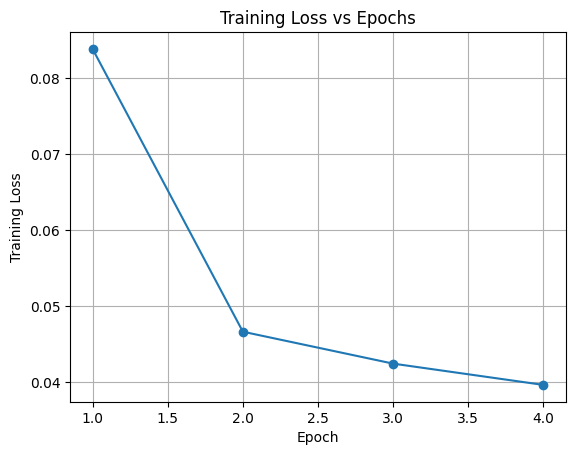

In [ ]:
import matplotlib.pyplot as plt

losses = [0.0838, 0.0466, 0.0424, 0.0396, 0.0346]  # add final epoch value

plt.plot(range(1, len(losses)+1), losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epochs")
plt.grid(True)
plt.show()